# Assignment #

Name: Haoyu(Andy) Li   zid: z5618900

## Part1  Topic Classification ##

(1) For the regex part, I am going to check each of the words if the initial or the last is English letter or a Arabic numerals. So that the phrases such as E-mail, C++ and COVID-19 will not be misclassified.

For the evaluation part, I am going to use 5-fold cross-validation because one training-test split is easily avioded by randomness.


(2) Multinomial Naive Bayes (MNB) model

In [85]:
# Step 1 Loading the data
import pandas as pd

df = pd.read_csv('dataset.tsv', sep='\t')
# Step 2 Initial data cleaning
df = df.dropna(subset=['lyrics', 'topic']) # The lyrics serve as the foundation for classification
df['text_raw'] = (
    df['artist_name'].fillna('') + ' ' +
    df['track_name'].fillna('')  + ' ' +
    df['genre'].fillna('')       + ' ' +
    df['lyrics']
)

In [86]:
# Step 3 Text preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
NEGATIONS = {"no", "nor", "not", "never", "n't", "do"}
stop_words -= NEGATIONS
lemmatizer = WordNetLemmatizer()
def initial_end_symbols(tok: str) -> bool:
    if not tok:
        return False
    return not tok[0].isalnum() and not tok[-1].isalnum()
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    cleaned = []
    for tok in tokens:
        if initial_end_symbols(tok):
            continue
        if tok in stop_words:
            continue
        tok = lemmatizer.lemmatize(tok,'v')
        tok = lemmatizer.lemmatize(tok,'n')
        cleaned.append(tok)
    return ' '.join(cleaned)
df['text_clean'] = df['text_raw'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rog\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rog\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Summary

1.The negation words in stop_words should not be replaced in text classification. So the stop_words is defined by stop_words - negation words.

2.The definition of a symbol word is the word which initial and end letters are not both a symbol. So that the words such as E-mail C++ and Covid-19 which are absolutely English words would not be replaced.

3.The words need to be lowercasing

4.For the lemmatization part, verbs should be converted to their base form, and plural nouns to singular.




In [87]:
# Step 4 Model training
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import BernoulliNB

X = df['text_clean']
y = df['topic']
mnb_model = make_pipeline(
    CountVectorizer(),
    MultinomialNB()
)

bnb_model = make_pipeline(
    CountVectorizer(binary=True),
    BernoulliNB()
)

(3) Compare BNB and MNB models

        Model  Accuracy_Mean  Accuracy_Standard_deviation  MacroF1_Mean  MacroF1_Standard_deviation
MultinomialNB          0.810                     0.017385      0.758444                    0.029114
  BernoulliNB          0.536                     0.024531      0.342709                    0.020625


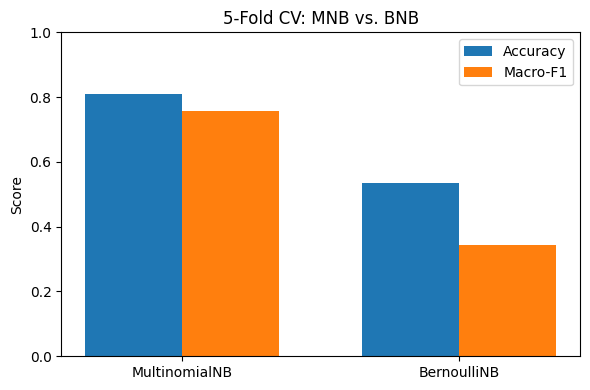

In [88]:
# Step 5 Model compare
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
def model_evaluation(model, name):
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    f1  = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")
    return {
        "Model": name,
        "Accuracy_Mean": acc.mean(),
        "Accuracy_Standard_deviation":   acc.std(),
        "MacroF1_Mean":  f1.mean(),
        "MacroF1_Standard_deviation":    f1.std(),
    }

results = pd.DataFrame([
    model_evaluation(mnb_model, "MultinomialNB"),
    model_evaluation(bnb_model, "BernoulliNB")
])

print(results.to_string(index=False))

fig, ax = plt.subplots(figsize=(6, 4))
pos = [0, 1]
width = 0.35

ax.bar([p - width/2 for p in pos],
       results["Accuracy_Mean"],
       width=width, label="Accuracy")

ax.bar([p + width/2 for p in pos],
       results["MacroF1_Mean"],
       width=width, label="Macro-F1")

ax.set_xticks(pos)
ax.set_xticklabels(results["Model"])
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_title("5-Fold CV: MNB vs. BNB")
ax.legend()
plt.tight_layout()
plt.show()

The reason why accuracy and macro-F1 are chosen is that the distribution of the label is not averaged. The topic of emotion is only 5% of the all label and lifestyle is 14%. Accuracy reflects the model’s overall performance, and macro-F1 assesses whether the model also gives sufficient attention to those minority classes.

From the table, it is easy to find MNB perform better than BNB for both of the accuracy and macro-F1. The bar chart does not plot the standard deviation is because there is no significant difference between them.

MNB is superior










(4) Varying the number of features

    N Model  Accuracy  MacroF1    Score
  100   MNB  0.755333 0.734901 0.745117
  100   BNB  0.552667 0.465158 0.508913
  500   MNB  0.874667 0.861064 0.867865
  500   BNB  0.648667 0.563041 0.605854
 1000   MNB  0.862000 0.844672 0.853336
 1000   BNB  0.640000 0.533284 0.586642
 5000   MNB  0.827333 0.791124 0.809229
 5000   BNB  0.565333 0.392420 0.478877
10000   MNB  0.810000 0.758444 0.784222
10000   BNB  0.536000 0.342709 0.439355


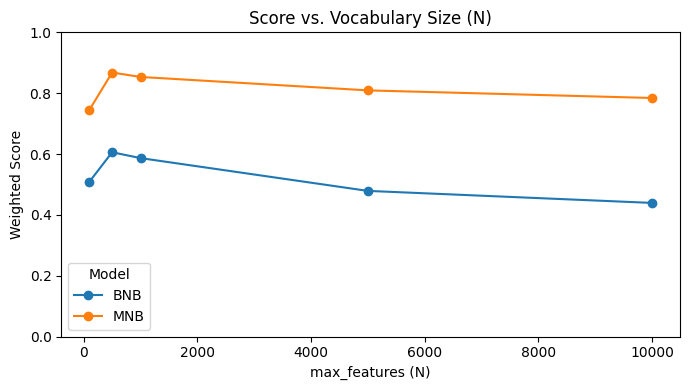

In [89]:
N_value = [100,500,1000,5000,10000]

N_records = []
for n in N_value:
    N_mnb = make_pipeline(
        CountVectorizer(max_features=n), #Set the N_value
        MultinomialNB()
    )

    N_bnb = make_pipeline(
        CountVectorizer(max_features=n, binary=True),
        BernoulliNB()
    )

    for name, model in [("MNB", N_mnb), ("BNB", N_bnb)]:
        acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
        f1  = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")
        N_records.append({
            "N": n,
            "Model": name,
            "Accuracy": acc.mean(),
            "MacroF1": f1.mean(),
        })

N_results = pd.DataFrame(N_records)
N_results["Score"] = 0.5 * N_results["Accuracy"] + 0.5 * N_results["MacroF1"]
print(N_results.to_string(index=False))


pivot_score = N_results.pivot(index="N", columns="Model", values="Score")

fig, ax = plt.subplots(figsize=(7, 4))
pivot_score.plot(kind="line", marker="o", ax=ax)
ax.set_xlabel("max_features (N)")
ax.set_ylabel("Weighted Score")
ax.set_title("Score vs. Vocabulary Size (N)")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()


N_values are firstly set from 100-10000. From the plot, the score(0.5 * acc+0.5 * F1) reaches the peak when N = 500. And it decreased as N comes larger. So the best N should be local around 500.

  N Model  Accuracy  MacroF1    Score
100   MNB  0.755333 0.734901 0.745117
100   BNB  0.552667 0.465158 0.508913
200   MNB  0.829333 0.813071 0.821202
200   BNB  0.618000 0.530992 0.574496
300   MNB  0.861333 0.852822 0.857078
300   BNB  0.628000 0.548196 0.588098
400   MNB  0.876000 0.865458 0.870729
400   BNB  0.649333 0.574026 0.611680
500   MNB  0.874667 0.861064 0.867865
500   BNB  0.648667 0.563041 0.605854
600   MNB  0.869333 0.855349 0.862341
600   BNB  0.645333 0.556200 0.600767
700   MNB  0.864000 0.850655 0.857327
700   BNB  0.645333 0.547871 0.596602
800   MNB  0.866000 0.853765 0.859882
800   BNB  0.638667 0.534934 0.586800
900   MNB  0.864667 0.850449 0.857558
900   BNB  0.634667 0.534590 0.584629


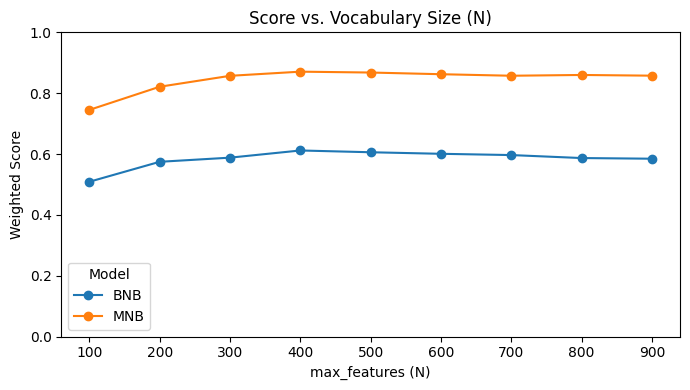

In [90]:
N_value = [100,200,300,400,500,600,700,800,900]

N_records = []
for n in N_value:
    N_mnb = make_pipeline(
        CountVectorizer(max_features=n),
        MultinomialNB()
    )

    N_bnb = make_pipeline(
        CountVectorizer(max_features=n, binary=True),
        BernoulliNB()
    )

    for name, model in [("MNB", N_mnb), ("BNB", N_bnb)]:
        acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
        f1  = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")
        N_records.append({
            "N": n,
            "Model": name,
            "Accuracy": acc.mean(),
            "MacroF1": f1.mean(),
        })

N_results = pd.DataFrame(N_records)
N_results["Score"] = 0.5 * N_results["Accuracy"] + 0.5 * N_results["MacroF1"]
print(N_results.to_string(index=False))


pivot_score = N_results.pivot(index="N", columns="Model", values="Score")

fig, ax = plt.subplots(figsize=(7, 4))
pivot_score.plot(kind="line", marker="o", ax=ax)
ax.set_xlabel("max_features (N)")
ax.set_ylabel("Weighted Score")
ax.set_title("Score vs. Vocabulary Size (N)")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()


Finally, N_values are chosen from 100-1000. Based on experimental results, **400** for N that works well overall

(5) Linear Support Vector Machine

Linear Support Vector Machine finds a separating hyper-plane that maximises the margin in a high-dimensional, linearly separable space—perfect for sparse, high-dimensional text data. CountVectorizer changes the text into bag of words matrix. Linear SVM handles this extremely sparse matrix natively.

For the hyperparameters part, Linearsvc is able to set the class_weight. So it is crucial to summarize the distribution of the label of dataset at the beginning. The weights are defined as the reciprocal of the numbers of the label. By the N_value in question(4), the best N_value of MNB and BNB has been found(N = 400). But it may not fit the svm model. Meanwhile, the regularisation (penalty) parameter C should also change as well. As the assumption, N might be bigger and C might be less than 1. After the adjustment part, the acc and F1 of Linear Support Vector might be close to MNB or better than MNB.


        Model  Accuracy_Mean  Accuracy_Standard_deviation  MacroF1_Mean  MacroF1_Standard_deviation
MultinomialNB       0.876000                     0.022050      0.865458                    0.028186
  BernoulliNB       0.649333                     0.032890      0.574026                    0.030029
    LinearSVC       0.883333                     0.015635      0.865714                    0.016692


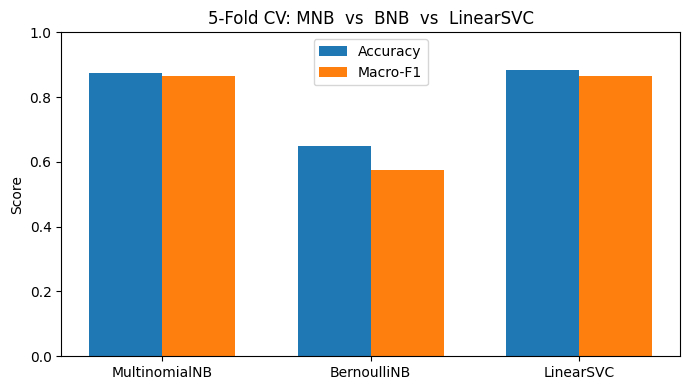

In [91]:
from sklearn.svm import LinearSVC

class_weight = {
    "dark": 1/490,
    "emotion": 1/82,
    "lifestyle": 1/205,
    "personal": 1/347,
    "sadness": 1/376,
}

svm_model = make_pipeline(
    CountVectorizer(max_features = 7000),
    LinearSVC(class_weight = class_weight, C=0.4, max_iter=10000),
)
mnb_final = make_pipeline(
    CountVectorizer(max_features = 400),
    MultinomialNB()
)

bnb_final = make_pipeline(
    CountVectorizer(max_features=400, binary=True),
    BernoulliNB()
)
results_final = pd.DataFrame([
    model_evaluation(mnb_final, "MultinomialNB"),
    model_evaluation(bnb_final, "BernoulliNB"),
    model_evaluation(svm_model, "LinearSVC"),
])
print(results_final.to_string(index=False))


fig, ax = plt.subplots(figsize=(7, 4))
pos   = list(range(len(results_final)))   # [0,1,2]
width = 0.35

ax.bar([p - width/2 for p in pos],
       results_final["Accuracy_Mean"],
       width=width, label="Accuracy")

ax.bar([p + width/2 for p in pos],
       results_final["MacroF1_Mean"],
       width=width, label="Macro-F1")

ax.set_xticks(pos)
ax.set_xticklabels(results_final["Model"])
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_title("5-Fold CV: MNB  vs  BNB  vs  LinearSVC")
ax.legend()
plt.tight_layout()
plt.show()

## Results ##

The same data pre-process and model_evaluation as question(3), the results confirmed the previous assumption that both of the acc and F1-score of LinearSVC is better than MNB and BNB. The overall "best" model is LinearSVC with class_weight = the reciprocal of the numbers of the label. And max_iter=10000,C = 0.4.



## Part 2 Recommendation Methods ##

(1)

In [92]:
# Divide train and test dataset
train_df = df.iloc[:750].copy()
test_df  = df.iloc[750:1000].copy()
X_train = train_df['text_clean']
y_train = train_df['topic']

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_train)
train_df["pred_topic"] = y_pred

# Split the training set into topics
topic_groups = train_df.groupby('pred_topic')

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define a user profile which consists of a vector for each of the five topics.
topic_tfidf_matrices = {}
topic_profile_vectors = {}

for topic, group in topic_groups:
    tfidf = TfidfVectorizer(max_features=400)
    X_topic = tfidf.fit_transform(group['text_clean'])
    topic_tfidf_matrices[topic] = (X_topic, tfidf)

    big_doc = " ".join(group['text_clean'])
    profile_vec = tfidf.transform([big_doc])
    topic_profile_vectors[topic] = profile_vec

In [94]:
# Read user1 interests from user1.tsv
user1_interest = {}
with open("user1.tsv", "r") as f:
    for line in f:
        topic, keywords = line.strip().split('\t')
        user1_interest[topic.strip()] = [w.strip() for w in keywords.split(',')]
# Create an empty list of songs User1 likes.
user1_liked_songs = []

for topic, keywordlist in user1_interest.items():
    for idx, row in train_df.iterrows():
        if row['pred_topic'] == topic:
            # When keywords match the keywordlist of user1
            if any(keyword in row['text_clean'].split() for keyword in keywordlist):
                user1_liked_songs.append(idx) # Now, we only get the number of the row.
# Location liked songs in the train_df
user1_liked_df = train_df.loc[user1_liked_songs]

In [95]:
# Define a user profile for user1
user1_profile_vectors = {}
for topic, group in user1_liked_df.groupby('pred_topic'):
    profile_doc = " ".join(group['text_clean'])
    tfidf = TfidfVectorizer(max_features=400)
    tfidf_vec = tfidf.fit_transform([profile_doc])
    user1_profile_vectors[topic.lower()] = tfidf_vec.toarray().ravel()
    tfidf_terms = np.array(tfidf.get_feature_names_out())
    # Print the top 20 words in their profiles for each of the topics.
    top_idx = np.argsort(tfidf_vec.toarray()[0])[::-1][:20]
    top20 = [w for w in tfidf_terms[top_idx]]
    interest_keywords = [w for w in user1_interest[topic]]
    hits = [kw for kw in interest_keywords if kw in top20]

    print(f"\nUser 1 profile — Topic: {topic}")
    print("Top 20 words:", top20)
    print(f"Interest keywords in top20: {len(hits)} / {len(interest_keywords)}")
    print("Matched keywords:", hits)


User 1 profile — Topic: dark
Top 20 words: ['fight', 'know', 'like', 'black', 'blood', 'na', 'stand', 'tell', 'come', 'gon', 'grind', 'hand', 'kill', 'head', 'time', 'yeah', 'cause', 'heart', 'feel', 'leave']
Interest keywords in top20: 1 / 5
Matched keywords: ['fight']

User 1 profile — Topic: emotion
Top 20 words: ['good', 'feel', 'touch', 'know', 'hold', 'want', 'morning', 'kiss', 'time', 'na', 'baby', 'vision', 'love', 'miss', 'like', 'cause', 'video', 'heart', 'look', 'loove']
Interest keywords in top20: 3 / 5
Matched keywords: ['love', 'kiss', 'feel']

User 1 profile — Topic: lifestyle
Top 20 words: ['night', 'song', 'come', 'long', 'time', 'sing', 'home', 'right', 'na', 'know', 'yeah', 'closer', 'play', 'like', 'tire', 'wan', 'wait', 'tonight', 'blue', 'spoil']
Interest keywords in top20: 1 / 5
Matched keywords: ['night']

User 1 profile — Topic: personal
Top 20 words: ['life', 'live', 'know', 'na', 'change', 'world', 'yeah', 'time', 'like', 'dream', 'come', 'think', 'thing', '

In [96]:
# Read user2 interests from user2.tsv
user2_interest = {}
with open("user2.tsv", "r") as f:
    for line in f:
        topic, keywords = line.strip().split('\t')
        user2_interest[topic.strip()] = [w.strip() for w in keywords.split(',')]

# Create an empty list of songs User2 likes.
user2_liked_songs = []
for topic, keywordlist in user2_interest.items():
    for idx, row in train_df.iterrows():
        if row['pred_topic'] == topic:
            # When keywords match the keywordlist of user2
            if any(keyword in row['text_clean'].split() for keyword in keywordlist):
                user2_liked_songs.append(idx) # Now, we only get the number of the row.
# Location liked songs in the train_df
user2_liked_df = train_df.loc[user2_liked_songs]

# Define a user profile for user2
user2_profile_vectors = {}
for topic, group in user2_liked_df.groupby('pred_topic'):
    profile_doc = " ".join(group['text_clean'])
    tfidf = TfidfVectorizer(max_features=400)
    tfidf_vec = tfidf.fit_transform([profile_doc])
    user2_profile_vectors[topic.lower()] = tfidf_vec.toarray().ravel()
    tfidf_terms = np.array(tfidf.get_feature_names_out())
    # Print the top 20 words in their profiles for each of the topics.
    top_idx = np.argsort(tfidf_vec.toarray()[0])[::-1][:20]
    top20 = [w for w in tfidf_terms[top_idx]]
    interest_keywords = [w for w in user2_interest[topic]]
    hits = [kw for kw in interest_keywords if kw in top20]

    print(f"\nUser 2 profile — Topic: {topic}")
    print("Top 20 words:", top20)
    print(f"Interest keywords in top20: {len(hits)} / {len(interest_keywords)}")
    print("Matched keywords:", hits)



User 2 profile — Topic: emotion
Top 20 words: ['touch', 'good', 'hold', 'kiss', 'morning', 'vision', 'video', 'know', 'loove', 'time', 'feel', 'luck', 'lovin', 'sunrise', 'lip', 'gim', 'like', 'go', 'wait', 'yeah']
Interest keywords in top20: 2 / 5
Matched keywords: ['touch', 'kiss']

User 2 profile — Topic: sadness
Top 20 words: ['heart', 'break', 'inside', 'away', 'like', 'step', 'know', 'fall', 'come', 'leave', 'fade', 'go', 'na', 'feel', 'scar', 'think', 'tear', 'blame', 'hard', 'open']
Interest keywords in top20: 0 / 5
Matched keywords: []


Evaluation (Comments)

For the evaluation part, a system is reasonable or not , is technically defined by how many keywords in user1.tsv and user2 that top-20 covers.

**Technically**, the words is not reasonable because the average hit_score is only 10/35 = 2/7.

**However**, by manually analyzing these words, even though the keywords themselves do not appear, these words are still highly related to the topic. Therefore, from a human perspective, these words are still considered quite reasonable.

User 3

In [97]:
# Read user3 interests from user3.tsv
user3_interest = {}
with open("user3.tsv", "r") as f:
    for line in f:
        topic, keywords = line.strip().split('\t')
        user3_interest[topic.strip()] = [w.strip() for w in keywords.split(',')]

# Create an empty list of songs User3 likes.
user3_liked_songs = []
for topic, keywordlist in user3_interest.items():
    for idx, row in train_df.iterrows():
        if row['pred_topic'] == topic:
            # When keywords match the keywordlist of user3
            if any(keyword in row['text_clean'].split() for keyword in keywordlist):
                user3_liked_songs.append(idx) # Now, we only get the number of the row.
# Location liked songs in the train_df
user3_liked_df = train_df.loc[user3_liked_songs]

# Define a user profile for user3
user3_profile_vectors = {}
for topic, group in user3_liked_df.groupby('pred_topic'):
    profile_doc = " ".join(group['text_clean'])
    tfidf = TfidfVectorizer(max_features=400)
    tfidf_vec = tfidf.fit_transform([profile_doc])
    user3_profile_vectors[topic.lower()] = tfidf_vec.toarray().ravel()
    tfidf_terms = np.array(tfidf.get_feature_names_out())
    top_idx = np.argsort(tfidf_vec.toarray()[0])[::-1][:20]
    top20 = [w for w in tfidf_terms[top_idx]]
    interest_keywords = [w for w in user3_interest[topic]]
    hits = [kw for kw in interest_keywords if kw in top20]

    print(f"\nUser 3 profile — Topic: {topic}")
    print("Top 20 words:", top20)
    print(f"Interest keywords in top20: {len(hits)} / {len(interest_keywords)}")
    print("Matched keywords:", hits)


User 3 profile — Topic: dark
Top 20 words: ['come', 'know', 'fear', 'black', 'night', 'na', 'feel', 'fight', 'hand', 'tell', 'time', 'hear', 'like', 'head', 'light', 'gon', 'blood', 'stand', 'heart', 'death']
Interest keywords in top20: 2 / 5
Matched keywords: ['night', 'fear']

User 3 profile — Topic: emotion
Top 20 words: ['good', 'go', 'hold', 'heart', 'feel', 'know', 'darling', 'vision', 'love', 'miss', 'video', 'hand', 'vibe', 'na', 'baby', 'want', 'lovin', 'right', 'time', 'gim']
Interest keywords in top20: 2 / 5
Matched keywords: ['love', 'heart']


The words in User 3 is technically more reasonable than User 1 and 2 because the average goes to 2/5 which is larger than 2/7. The words are also highly related to the topic. So totally they are reasonable.

(2)

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

N = 20 # Number of songs to recommend per user
M = 20 # Number of top keywords to keep in user profile
# Predict song topics using svm_model
test_df['pred_topic'] = svm_model.predict(test_df['text_clean'])
user_rec_dict = {}
for user_name, user_interest in [
    ("User1", user1_interest),
    ("User2", user2_interest),
    ("User3", user3_interest),
]:
    rec_indices = []
    for topic in user_interest:
        topic_lower = topic.lower()
        train_topic_songs = train_df[train_df['pred_topic'].str.lower() == topic_lower]
        if train_topic_songs.empty:
            continue

        tfidf = TfidfVectorizer(max_features=400)
        tfidf.fit(train_topic_songs['text_clean'])
        liked_songs = train_topic_songs.copy()
        profile_doc = " ".join(liked_songs['text_clean'])
        profile_vec = tfidf.transform([profile_doc]).toarray().ravel()

        if M is not None and M < len(profile_vec):
            topM_idx = np.argsort(profile_vec)[::-1][:M]
            mask = np.zeros_like(profile_vec)
            mask[topM_idx] = 1
            profile_vec = profile_vec * mask

        test_topic_songs = test_df[test_df['pred_topic'].str.lower() == topic_lower]
        if test_topic_songs.empty:
            continue
        X_test = tfidf.transform(test_topic_songs['text_clean'])
        # Compute cosine similarity between user profile and each test song
        sim = cosine_similarity([profile_vec], X_test.toarray())[0]

        topN_idx = np.argsort(sim)[::-1][:N]
        topic_indices = test_topic_songs.iloc[topN_idx].index.tolist()
        rec_indices.extend(topic_indices)
    rec_indices = list(dict.fromkeys(rec_indices))[:N]
    recommended_songs = test_df.loc[rec_indices]
    user_rec_dict[user_name] = recommended_songs

    print(f"\n {user_name} Recommend ")
    for _, row in recommended_songs.iterrows():
        print(f"{row['track_name']} — {row['artist_name']}")



 User1 Recommend 
naked — james arthur
boy in the bubble — alec benjamin
black — dierks bentley
moon river — nicole henry
around the corner — rick braun
stigmata — grandson
am i going up? — all them witches
the flame (is gone) — the dear hunter
lest we forget (blood) — esperanza spalding
love is alive — louis the child
black kennedy — august greene
new beginning — radio moscow
no new friends (feat. sia, diplo, and labrinth) — sia
notorious — adelitas way
whiskey fever — dorothy
vaadi nee vaa — hiphop tamizha
do your worst — rival sons
donner bell — deca
you should see me in a crown — billie eilish
black betty — larkin poe

 User2 Recommend 
the fighter — keith urban
love falls — hellyeah
truly madly deeply — yoke lore
cry to me — skip marley
balcony — lester nowhere
one call away — charlie puth
cranes in the sky — solange
chocolatize — brant bjork
the greatest — six60
our hearts (feat. lucie silvas) — randy houser
fallin (feat. 6lack) — bazzi
we find love — daniel caesar
amsterdam — n

In [99]:
recommended_songs_user1 = user_rec_dict["User1"]
recommended_songs_user2 = user_rec_dict["User2"]
recommended_songs_user3 = user_rec_dict["User3"]
for user_name, user_interest, recommended_songs in [
    ("User1", user1_interest, recommended_songs_user1),
    ("User2", user2_interest, recommended_songs_user2),
    ("User3", user3_interest, recommended_songs_user3),
]:

    interest_topics = set([t.lower() for t in user_interest])

    y_pred = [1 if t.lower() in interest_topics else 0 for t in recommended_songs['pred_topic']]

    all_interest_songs = test_df[test_df['pred_topic'].str.lower().isin(interest_topics)]
    n_all_interest = len(all_interest_songs)

    precision = sum(y_pred) / len(y_pred) if len(y_pred) else 0
    recall = sum(y_pred) / n_all_interest if n_all_interest else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    print(f"\nUser: {user_name}")
    print(f"Recall:    {recall:.2%}")
    print(f"F1-score:  {f1:.2%}")




User: User1
Recall:    8.00%
F1-score:  14.81%

User: User2
Recall:    22.22%
F1-score:  36.36%

User: User3
Recall:    23.53%
F1-score:  38.10%


Summary

N = 20 (number of songs recommended per user) is chosen because, in real-world applications, users can only view a limited number of items at a time. Recommending too many songs will be meaningless to users, while too few may fail to capture their interests.

M = 20 (number of top keywords in the user profile) reduces the noisy successfully. After the comparing to using all words, it introduces non-informative words. If M is too small, it may miss important signals.

In question 2, as we define each user likes all and only those songs in the top N recommendations that matched their profile for the predicted topic. The precision can easily reach 100% due to the lack of topics. So I choose Recall and F1-score.

User1,2,3 do not have the same numbers of topics so the Recall and F1-score might be different between them.

At the beginning of this part, I use "Keyword" match and all scores become 100%. Because in real world the system can only guess what topic that users are interested in base on the "users profile". Cosine similarity is a standard metric for measuring the similarity between two vectors in text mining and recommender systems.

# Part 3 #

In [128]:
week1_df = df.iloc[0:250].copy()
week2_df = df.iloc[250:500].copy()
week3_df = df.iloc[500:750].copy()
week4_df = df.iloc[750:1000].copy()

np.random.seed(25)
user_likes = pd.DataFrame()

for week_df in [week1_df, week2_df, week3_df]:
    sample = week_df.sample(n=N, random_state=np.random.randint(10000)).copy()
    # The choices from my friend
    liked_indices = [3,8,79,145,171,80,230,220,17,469,412,458,391,319,741,617,509,579,535,663]
    sample['like'] = 0
    sample.loc[sample.index.isin(liked_indices), 'like'] = 1
    user_likes = pd.concat([user_likes, sample])
# Songs that my friend likes
liked_songs = user_likes[user_likes['like']==1]

profile_doc = " ".join(liked_songs['text_clean'])
vectorizer = TfidfVectorizer(max_features=400)
# Fit with the songs that my friend likes
vectorizer.fit(liked_songs['text_clean'])
profile_vec = vectorizer.transform([profile_doc]).toarray().ravel()
if M is not None and M < len(profile_vec):
    topM_idx = np.argsort(profile_vec)[::-1][:M]
    mask = np.zeros_like(profile_vec)
    mask[topM_idx] = 1
    profile_vec = profile_vec * mask

# Recommendations for my friend in week 4
X_week4 = vectorizer.transform(week4_df['text_clean'])
sim = cosine_similarity([profile_vec], X_week4.toarray())[0]
topN_idx = np.argsort(sim)[::-1][:N]
recommended_songs = week4_df.iloc[topN_idx].copy()

print("\nSongs Recommendations in Week 4 ")
for _, row in recommended_songs.iterrows():
    print(f"{row['track_name']} — {row['artist_name']}")
# # The choices from my friend in week 4
week_4_liked_indices = [860,918,952,861,994,814,929]
recommended_songs.loc[:, 'like'] = 0
recommended_songs.loc[recommended_songs.index.isin(week_4_liked_indices), 'like'] = 1
# Songs that my friend likes in week 4
week_4_liked_songs = recommended_songs[recommended_songs['like']==1]
print(week_4_liked_songs)


Songs Recommendations in Week 4 
alta — ty segall
close enough — brett young
wash away — iya terra
sunday morning — axian
rocky road — alborosie
redneck life — chris janson
balcony — lester nowhere
gratitude — car bomb
let you love me — rita ora
why we die (feat. dmx and jay z) — busta rhymes
don't throw it away — jonas brothers
light years — the national
call me — walshy fire
100% — trina
swarm — thank you scientist
everything to me — soja
cranes in the sky — solange
happiness — needtobreathe
one call away — charlie puth
ghost of you — 5 seconds of summer
             artist_name           track_name  release_date    genre  \
860          brett young         close enough          2017  country   
918             car bomb            gratitude          2016     jazz   
814             rita ora      let you love me          2018      pop   
952       jonas brothers  don't throw it away          2019      pop   
994         the national          light years          2019     rock   
861 

In [132]:
# Evaluation
# There are 7 Songs that my friend likes in week 4
precision = 7 / N
recall = 7 / (N + 7)
f1 = 2 * precision * recall / (precision + recall)
print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1-score:  {f1:.2%}")

Precision: 35.00%
Recall:    25.93%
F1-score:  29.79%


Summary

It is easy to see that compared to the results in part 2, part 3 performs worse in terms of precision, recall, and F1 score. This is because in part 2, each user has their own preferred topic, and a recommendation is considered successful as long as the recommended song matches this topic. However, if we apply this to real-world scenarios and evaluate the recommendations from a human perspective, the complexity increases significantly.

During my conversations with my friend, I found that he had actually never heard many of the songs before, so letting him listen to the songs in the early stage was essential to find out which ones he liked. My friend told me that many of the songs recommended in the week4 had similar themes and melodies to the songs he liked in the previous three weeks, but they were not accepted because the timbre or singing style was different. Overall, the recommendation system did manage to recommend some songs that my friend enjoyed in real life, but it still did not achieve a high level of accuracy.

